In [1]:
# module Import

# %matplotlib inline
import matplotlib.pyplot as plt # pip install matplotlib
from CIMtools.preprocessing import Fragmentor # pip install pillow==9.4.0
from CIMtools.preprocessing import solvent
from os import environ

## environ['PATH']+=":/home/pavel/envs/cgr/bin"
## needs to be reassigned if ISIDA descriptor generation is needed

from CGRtools import RDFRead, MoleculeContainer, ReactionContainer, SDFRead, SMILESRead, smiles, CGRContainer  # pip install CGRtools
import pandas as pd  # pip install pandas
from pandas import DataFrame 
import numpy as np
import pickle 

from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score, KFold, cross_val_predict, GridSearchCV, train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVR
from sklearn.datasets import load_svmlight_file, dump_svmlight_file
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error as mae

from scipy.optimize import curve_fit

from ChemInfoTools.cheminfotools.chem_features import Augmentor, ComplexFragmentor, PassThrough, Pruner

import itertools
import xgboost # pip install xgboost
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor # pip install catboost

import torch
import torch.nn as nn
import torch.optim as optim

from rdkit import Chem
from rdkit.Chem import EState, Descriptors
from rdkit.Chem import GetPeriodicTable

%config IPCompleter.use_jedi = False
cm = 1./2.54

In [2]:
!pip install pubchempy



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Data preparation

### Load Data

In [3]:
# Get Data from Excel  : 엑셀에서 데이터 불러오기
FileName = "final_data.csv" 
data_molecules = pd.read_csv(FileName)
data_molecules.fillna('')
data_molecules = data_molecules.dropna()

In [4]:
data_molecules

,smiles,BBB
0,OCc1ccccc1,1
1,CC(NC(C)(C)C)C(=O)c1cccc(c1)Cl,1
2,NCCc1ccc(c(c1)O)O DOPAMINE,0
3,NC(=O)c1cccnc1,1
4,CN1CCCC1c1cccnc1,1
...,...,...
3045,CC(C)c1ccc(C)cc1OCC2=NCCN2,0
3046,CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...,0
3047,CC(C)C1OC(=O)C2=CCCN2C(=O)c3coc(CC(=O)CC(O)\C=...,0
3048,Oc1ccc(cc1)/C=C([N+]#[C-])/C(=C/c2ccc(O)cc2)[N...,0


### Drop NAs

In [5]:
# dropna with target : 예측하고자하는 결과값이 없는 행들을 제거
target = 'BBB' # ee, yield, ddG(free energy difference), regio 타겟 설정

print(len(data_molecules))
data_molecules.dropna(subset=[target], inplace=True)
print(len(data_molecules))


3050
3050


# Models

In [6]:
random_seed = 42

# Before Training

### data split

In [7]:
target_column = "BBB"
train_df = data_molecules.drop(columns=[target_column])
target_df = data_molecules[[target_column]]

In [8]:
#중복 여부 확인
smiles_column = train_df.columns[0]  # 첫 번째 열이 SMILES라고 가정
smiles_list = train_df[smiles_column]

# 중복 여부 확인
duplicate_smiles = smiles_list[smiles_list.duplicated(keep=False)]  # 중복된 값만 선택
duplicate_counts = duplicate_smiles.value_counts()  # 각 중복된 SMILES의 개수

# 결과 출력
if not duplicate_counts.empty:
    print(f"🔍 총 {len(duplicate_counts)}개의 중복된 SMILES가 발견되었습니다.")
    print("\n📌 중복된 SMILES 목록 (등장 횟수):")
    print(duplicate_counts)
else:
    print("✅ 중복된 SMILES가 없습니다.")

✅ 중복된 SMILES가 없습니다.


 # SMILES -> RDkit -> PyTorch Geometric Data
 ## "변환 코드 (최종)"
 ### 확장 가능성 확인
 #### 결합 길이나 극성을 넣고 싶음 그거 고민ING...하다가 STOP

In [9]:
import torch
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem import rdmolops, AllChem
import numpy as np
from pubchempy import get_compounds

from rdkit import Chem
from rdkit.Chem import BRICS
from collections import Counter
import torch

# Pauling 전기음성도 값=>결합 간 전기음성도 차이를 edge 특성으로 사용
electronegativity = {
    "H": 2.20, "C": 2.55, "N": 3.04, "O": 3.44, "F": 3.98,
    "P": 2.19, "S": 2.58, "Cl": 3.16, "Br": 2.96, "I": 2.66
}

def get_electronegativity(atom):
    """원자의 전기음성도를 반환 (데이터에 없으면 0)"""
    symbol = atom.GetSymbol()
    return electronegativity.get(symbol, 0)

def atom_features(atom):
    """원자 특성 벡터 생성"""
    #원자번호, 형식 전하, 결합 수, 방향족 여부, 혼성 궤도, 수소 원자 수, 3D 위치
    pos = conf.GetAtomPosition(atom.GetIdx())
    return [
        atom.GetAtomicNum(),
        atom.GetFormalCharge(),
        atom.GetDegree(),
        int(atom.GetIsAromatic()),
        atom.GetHybridization().real,
        int(atom.GetTotalNumHs()),
        pos.x, pos.y, pos.z
    ]

def bond_features(bond):
    """결합 특성 벡터 생성"""
    bond_types = {
        Chem.rdchem.BondType.SINGLE: 1,
        Chem.rdchem.BondType.DOUBLE: 2,
        Chem.rdchem.BondType.TRIPLE: 3,
        Chem.rdchem.BondType.AROMATIC: 4
    }
    
    # 입체 화학 정보
    stereo_types = {
        Chem.rdchem.BondStereo.STEREONONE: 0,
        Chem.rdchem.BondStereo.STEREOANY: 1,
        Chem.rdchem.BondStereo.STEREOE: 2,
        Chem.rdchem.BondStereo.STEREOZ: 3
    }

    return [
        bond_types[bond.GetBondType()],
        int(bond.GetIsAromatic()),
        stereo_types[bond.GetStereo()]
    ]

def compute_bond_length(mol, bond):
    """결합 길이를 계산하는 함수 (예외 처리 추가)"""
    try:
        conf = mol.GetConformer()
        atom_i = bond.GetBeginAtomIdx()
        atom_j = bond.GetEndAtomIdx()
        pos_i = np.array(conf.GetAtomPosition(atom_i))
        pos_j = np.array(conf.GetAtomPosition(atom_j))
        bond_length = np.linalg.norm(pos_i - pos_j)

        if np.isnan(bond_length) or bond_length <= 0:
            raise ValueError(f"잘못된 결합 길이: {bond_length}")

        return bond_length
    except Exception as e:
        return -1  # 결합 길이 계산 실패 시 -1 반환

def build_fragment_vocab(data_molecules):
    """
    전체 데이터셋에서 BRICS fragment를 추출하고,
    고정된 fragment vocab과 인덱싱 딕셔너리를 생성합니다.
    """
    fragment_vocab = set()

    for smiles in data_molecules:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
        fragments = BRICS.BRICSDecompose(mol)
        fragment_vocab.update(fragments)

    fragment_list = sorted(list(fragment_vocab))
    fragment2idx = {frag: idx for idx, frag in enumerate(fragment_list)}

    return fragment2idx

def fragment_vector_from_mol(mol, fragment2idx, dim):
    """
    특정 molecule로부터 고정된 크기의 fragment vector를 생성합니다.
    """
    fragments = BRICS.BRICSDecompose(mol)
    counter = Counter(fragments)

    vec = torch.zeros(dim)
    for frag, count in counter.items():
        if frag in fragment2idx:
            vec[fragment2idx[frag]] = count  # 또는 presence만 보고 싶다면 `= 1`

    return vec

# 1. 데이터셋에서 BRICS fragment vocab 생성
fragment2idx = build_fragment_vocab(data_molecules['smiles'])

# 2. fc layer에서 사용 시:
frag_dim = len(fragment2idx)


graph_data_list = []
invalid_smiles_list = []

for idx, row in data_molecules.iterrows():
    smiles = row["smiles"]
   
    try:
        # SMILES 문자열을 RDKit Mol 객체로 변환
        mol = Chem.MolFromSmiles(smiles)
        if mol is None or mol.GetNumAtoms() == 0:
            raise ValueError("Invalid SMILES")

        # 3D 구조 생성 및 좌표 최적화
        mol = Chem.AddHs(mol)
        result = AllChem.EmbedMolecule(mol, randomSeed=42)
        if result != 0:
            raise ValueError(f"3D 구조 생성 실패 (SMILES: {smiles})")
        AllChem.UFFOptimizeMolecule(mol)

        # 원자 feature vector와 결합 feature 벡터 생성
        conf = mol.GetConformer()  # 추가

        x = torch.tensor([atom_features(atom) for atom in mol.GetAtoms()], dtype=torch.float)

        edge_index = []
        edge_attr = []

        for bond in mol.GetBonds():
            i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            edge_index.append((i, j))
            edge_index.append((j, i))

            atom_i = bond.GetBeginAtom()
            atom_j = bond.GetEndAtom()

            electroneg_diff = abs(get_electronegativity(atom_i) - get_electronegativity(atom_j))

            bond_length = compute_bond_length(mol, bond)  # 결합 길이 계산

            bond_feats = [electroneg_diff] + bond_features(bond) + [bond_length]
            edge_attr.append(bond_feats)
            edge_attr.append(bond_feats)

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)

        fragment = fragment_vector_from_mol(mol, fragment2idx, frag_dim)

        target_bbb = torch.tensor(row[target_column])

        graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, fragments = fragment, y=target_bbb)
        graph_data_list.append(graph_data)

    except Exception as e:
        print(f"⚠️ Error processing row {idx} (SMILES: {smiles}) - {e}")
        invalid_smiles_list.append((idx, smiles))

print(f"\n✅ Successfully converted {len(graph_data_list)} molecules into PyG graph format.")
print(f"❌ {len(invalid_smiles_list)} invalid SMILES found.")

if invalid_smiles_list:
    print("\n🔍 Invalid SMILES Details:")
    for row_idx, invalid_smiles in invalid_smiles_list:
        print(f"Row {row_idx}: {invalid_smiles}")

[19:00:59] WARNING: not removing hydrogen atom without neighbors
[19:01:00] WARNING: not removing hydrogen atom without neighbors
[19:01:00] WARNING: not removing hydrogen atom without neighbors
[19:01:00] WARNING: not removing hydrogen atom without neighbors
[19:01:03] Explicit valence for atom # 12 N, 4, is greater than permitted
[19:01:03] Explicit valence for atom # 5 N, 4, is greater than permitted
[19:01:03] Explicit valence for atom # 5 N, 4, is greater than permitted
[19:01:03] Explicit valence for atom # 5 N, 4, is greater than permitted
[19:01:03] WARNING: not removing hydrogen atom without neighbors
[19:01:06] WARNING: not removing hydrogen atom without neighbors
[19:01:08] WARNING: not removing hydrogen atom without neighbors
[19:02:14] UFFTYPER: Unrecognized charge state for atom: 1
[19:02:14] UFFTYPER: Unrecognized charge state for atom: 1


⚠️ Error processing row 1264 (SMILES: CO[C@@]12C=C[C@@]3(CC1C(C)(C)O)[C@H]1Cc4ccc(c5c4[C@@]3(CCN1CC1CC1)[C@H]2O5)O) - 3D 구조 생성 실패 (SMILES: CO[C@@]12C=C[C@@]3(CC1C(C)(C)O)[C@H]1Cc4ccc(c5c4[C@@]3(CCN1CC1CC1)[C@H]2O5)O)
⚠️ Error processing row 1269 (SMILES: Clc1ccc(cc1)[C@@H]1[C@H]2CC[C@@H](C2)C21CCC(=N2)N1CCOCC1) - 3D 구조 생성 실패 (SMILES: Clc1ccc(cc1)[C@@H]1[C@H]2CC[C@@H](C2)C21CCC(=N2)N1CCOCC1)
⚠️ Error processing row 1377 (SMILES: CN1[C@@H]2CC[C@@H]1CC(C2)OC(=O)C(O)c1ccccc1) - 3D 구조 생성 실패 (SMILES: CN1[C@@H]2CC[C@@H]1CC(C2)OC(=O)C(O)c1ccccc1)
⚠️ Error processing row 1509 (SMILES: CO[C@@]12CC[C@@]3(C[C@@H]1C(C)(C)O)[C@H]1Cc4ccc(c5c4[C@@]3(CCN1CC1CC1)[C@H]2O5)O) - 3D 구조 생성 실패 (SMILES: CO[C@@]12CC[C@@]3(C[C@@H]1C(C)(C)O)[C@H]1Cc4ccc(c5c4[C@@]3(CCN1CC1CC1)[C@H]2O5)O)
⚠️ Error processing row 1524 (SMILES: CO[C@H]1O[C@H]2O[C@@]3(CN4CCCCC4)[C@H](O)C[C@H](C2C)[C@@H]13) - 3D 구조 생성 실패 (SMILES: CO[C@H]1O[C@H]2O[C@@]3(CN4CCCCC4)[C@H](O)C[C@H](C2C)[C@@H]13)
⚠️ Error processing row 1590 (SMILES: CC(C)C[

[19:34:42] UFFTYPER: Unrecognized atom type: S_6+6 (1)
[19:34:42] UFFTYPER: Unrecognized atom type: S_6+6 (1)
[19:34:42] UFFTYPER: Unrecognized charge state for atom: 1
[19:34:42] UFFTYPER: Unrecognized charge state for atom: 1


⚠️ Error processing row 1960 (SMILES: O=c1cccc2n1C[C@@H]1CNC[C@@H]2C1) - 3D 구조 생성 실패 (SMILES: O=c1cccc2n1C[C@@H]1CNC[C@@H]2C1)
⚠️ Error processing row 2055 (SMILES: OC[C@H](c1ccccc1)C(=O)O[C@@H]1C[C@@H]2N([C@@H](C1)[C@H]1[C@H]2O1)C) - 3D 구조 생성 실패 (SMILES: OC[C@H](c1ccccc1)C(=O)O[C@@H]1C[C@@H]2N([C@@H](C1)[C@H]1[C@H]2O1)C)
⚠️ Error processing row 2083 (SMILES: N[C@@H]1[C@H]2[C@H]1CN(C2)c1nc2c(cc1F)c(=O)c(cn2c1ccc(cc1F)F)C(=O)O) - 3D 구조 생성 실패 (SMILES: N[C@@H]1[C@H]2[C@H]1CN(C2)c1nc2c(cc1F)c(=O)c(cn2c1ccc(cc1F)F)C(=O)O)
⚠️ Error processing row 2094 (SMILES: CN1[C@H]2CC[C@H]1C[C@@H](C2)OC(c1ccccc1)c1ccccc1) - 3D 구조 생성 실패 (SMILES: CN1[C@H]2CC[C@H]1C[C@@H](C2)OC(c1ccccc1)c1ccccc1)
⚠️ Error processing row 2130 (SMILES: O[C@@H](c1ccccc1)C(=O)OC1C[C@@H]2CC[C@@H](C1)N2C) - 3D 구조 생성 실패 (SMILES: O[C@@H](c1ccccc1)C(=O)OC1C[C@@H]2CC[C@@H](C1)N2C)
⚠️ Error processing row 2131 (SMILES: OC[C@H](c1ccccc1)C(=O)OC1C[C@@H]2CC[C@@H](C1)N2C) - 3D 구조 생성 실패 (SMILES: OC[C@H](c1ccccc1)C(=O)OC1C[C@@H]2CC[C@@H](C1

[19:37:52] WARNING: not removing hydrogen atom without neighbors
[19:38:22] WARNING: not removing hydrogen atom without neighbors
[19:38:22] WARNING: not removing hydrogen atom without neighbors
[19:38:22] WARNING: not removing hydrogen atom without neighbors
[19:39:39] Explicit valence for atom # 12 N, 4, is greater than permitted
[19:39:39] Explicit valence for atom # 5 N, 4, is greater than permitted
[19:39:39] Explicit valence for atom # 5 N, 4, is greater than permitted
[19:39:39] Explicit valence for atom # 5 N, 4, is greater than permitted


⚠️ Error processing row 2812 (SMILES: c1c(c(ncc1)CSCCN\C(=[NH]\C#N)NCC)Br) - Invalid SMILES
⚠️ Error processing row 2813 (SMILES: n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N) - Invalid SMILES
⚠️ Error processing row 2814 (SMILES: n1c(csc1\[NH]=C(\N)N)c1cccc(c1)NC(C)=O) - Invalid SMILES
⚠️ Error processing row 2815 (SMILES: n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N\C(NC)=[NH]\C#N) - Invalid SMILES


[19:39:43] WARNING: not removing hydrogen atom without neighbors
[20:03:26] WARNING: not removing hydrogen atom without neighbors
[20:16:03] WARNING: not removing hydrogen atom without neighbors



✅ Successfully converted 3027 molecules into PyG graph format.
❌ 23 invalid SMILES found.

🔍 Invalid SMILES Details:
Row 1264: CO[C@@]12C=C[C@@]3(CC1C(C)(C)O)[C@H]1Cc4ccc(c5c4[C@@]3(CCN1CC1CC1)[C@H]2O5)O
Row 1269: Clc1ccc(cc1)[C@@H]1[C@H]2CC[C@@H](C2)C21CCC(=N2)N1CCOCC1
Row 1377: CN1[C@@H]2CC[C@@H]1CC(C2)OC(=O)C(O)c1ccccc1
Row 1509: CO[C@@]12CC[C@@]3(C[C@@H]1C(C)(C)O)[C@H]1Cc4ccc(c5c4[C@@]3(CCN1CC1CC1)[C@H]2O5)O
Row 1524: CO[C@H]1O[C@H]2O[C@@]3(CN4CCCCC4)[C@H](O)C[C@H](C2C)[C@@H]13
Row 1590: CC(C)C[C@@H](NC(=O)[C@H](C)NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(=O)N[C@@H](C)C(=O)N[C@H](C(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@H](C(C)C)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@H](CC(C)C)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@H](CC(C)C)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@H](CC(C)C)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)NCCO GRAMICIDIN-A
Row 1592: CC(C)CC(NC(=O)C(C)NC(=O)CNC(=O)C(NC=O)C(C)C)C(=O)NC(C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(Cc1c[nH]c2ccccc12)C(=O)NC(CC(C)C)C(=O)NC(Cc1ccccc1)C(=O)

### fragment feature 추가

In [29]:
#fg_summary 열기
fg_summary = pd.read_csv("fg_summary_lee_plus.csv")
#df로 변환
fg_summary = pd.DataFrame(fg_summary)
#majority label이 "OUTSIDE"인 행만 필터링
fg_summary = fg_summary[fg_summary['majority_label'] == 'OUTSIDE']
#fg_summary의 smiles 열을 리스트로 변환
fg_smiles = fg_summary['fg_smarts'].tolist()
#OCCOP(=O)(OCCN)OC(COCCOCCO)CO 여기서 (COCCOCCO)의 마자막 O에 fg_smiles이어붙이기
lnp_smiles = ["OCCOP(=O)(OCCN)OC(COCCOCCO" + smiles + ")CO" for smiles in fg_smiles]
#이 lnp_smiles를 기존 df의 lnp_smiles 열에 추가
fg_summary['lnp_smiles'] = lnp_smiles

#negative_fg_summary_lee에 대해서도 같은 작업
#fg_summary 열기
nfg_summary = pd.read_csv("negative_fg_summary_lee.csv")
#df로 변환
nfg_summary = pd.DataFrame(nfg_summary)
#majority label이 "OUTSIDE"인 행만 필터링
nfg_summary = nfg_summary[nfg_summary['majority_label'] == 'OUTSIDE']
#nfg_summary의 smiles 열을 리스트로 변환
nfg_smiles = nfg_summary['fg_smarts'].tolist()
#OCCOP(=O)(OCCN)OC(COCCOCCO)CO 여기서 (COCCOCCO)의 마자막 O에 nfg_smiles이어붙이기
nlnp_smiles = ["OCCOP(=O)(OCCN)OC(COCCOCCO" + smiles + ")CO" for smiles in nfg_smiles]
#이 lnp_smiles를 기존 df의 lnp_smiles 열에 추가
nfg_summary['lnp_smiles'] = nlnp_smiles

In [30]:
lnp_graph_list = []
invalid_lnp_list = []
for sml in lnp_smiles:
   
    try:
        # SMILES 문자열을 RDKit Mol 객체로 변환
        mol = Chem.MolFromSmiles(sml)
        if mol is None or mol.GetNumAtoms() == 0:
            raise ValueError("Invalid SMILES")

        # 3D 구조 생성 및 좌표 최적화
        mol = Chem.AddHs(mol)
        result = AllChem.EmbedMolecule(mol, randomSeed=42)
        if result != 0:
            raise ValueError(f"3D 구조 생성 실패 (SMILES: {sml})")
        AllChem.UFFOptimizeMolecule(mol)

        # 원자 feature vector와 결합 feature 벡터 생성
        conf = mol.GetConformer()  # 추가

        x = torch.tensor([atom_features(atom) for atom in mol.GetAtoms()], dtype=torch.float)

        edge_index = []
        edge_attr = []

        for bond in mol.GetBonds():
            i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            edge_index.append((i, j))
            edge_index.append((j, i))

            atom_i = bond.GetBeginAtom()
            atom_j = bond.GetEndAtom()

            electroneg_diff = abs(get_electronegativity(atom_i) - get_electronegativity(atom_j))

            bond_length = compute_bond_length(mol, bond)  # 결합 길이 계산

            bond_feats = [electroneg_diff] + bond_features(bond) + [bond_length]
            edge_attr.append(bond_feats)
            edge_attr.append(bond_feats)

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)

        fragment = fragment_vector_from_mol(mol, fragment2idx, frag_dim)

        target_bbb = torch.tensor(row[target_column])

        graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, fragments = fragment, y=target_bbb)
        lnp_graph_list.append(graph_data)

    except Exception as e:
        print(f"⚠️ Error processing row {idx} (SMILES: {sml}) - {e}")
        invalid_lnp_list.append((idx, sml))

print(f"\n✅ Successfully converted {len(lnp_graph_list)} molecules into PyG graph format.")
print(f"❌ {len(invalid_lnp_list)} invalid SMILES found.")

if invalid_lnp_list:
    print("\n🔍 Invalid SMILES Details:")
    for row_idx, invalid_smiles in invalid_lnp_list:
        print(f"Row {row_idx}: {invalid_smiles}")




✅ Successfully converted 259 molecules into PyG graph format.
❌ 0 invalid SMILES found.


In [12]:
lnp_graph_list_neg = []
invalid_lnp_neg_list = []

for sml in nlnp_smiles:
   
    try:
        # SMILES 문자열을 RDKit Mol 객체로 변환
        mol = Chem.MolFromSmiles(sml)
        if mol is None or mol.GetNumAtoms() == 0:
            raise ValueError("Invalid SMILES")

        # 3D 구조 생성 및 좌표 최적화
        mol = Chem.AddHs(mol)
        result = AllChem.EmbedMolecule(mol, randomSeed=42)
        if result != 0:
            raise ValueError(f"3D 구조 생성 실패 (SMILES: {sml})")
        AllChem.UFFOptimizeMolecule(mol)

        # 원자 feature vector와 결합 feature 벡터 생성
        conf = mol.GetConformer()  # 추가

        x = torch.tensor([atom_features(atom) for atom in mol.GetAtoms()], dtype=torch.float)

        edge_index = []
        edge_attr = []

        for bond in mol.GetBonds():
            i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            edge_index.append((i, j))
            edge_index.append((j, i))

            atom_i = bond.GetBeginAtom()
            atom_j = bond.GetEndAtom()

            electroneg_diff = abs(get_electronegativity(atom_i) - get_electronegativity(atom_j))

            bond_length = compute_bond_length(mol, bond)  # 결합 길이 계산

            bond_feats = [electroneg_diff] + bond_features(bond) + [bond_length]
            edge_attr.append(bond_feats)
            edge_attr.append(bond_feats)

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)

        fragment = fragment_vector_from_mol(mol, fragment2idx, frag_dim)

        target_bbb = torch.tensor(row[target_column])

        graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, fragments = fragment, y=target_bbb)
        lnp_graph_list_neg.append(graph_data)

    except Exception as e:
        print(f"⚠️ Error processing row {idx} (SMILES: {sml}) - {e}")
        invalid_lnp_neg_list.append((idx, sml))

print(f"\n✅ Successfully converted {len(lnp_graph_list_neg)} molecules into PyG graph format.")
print(f"❌ {len(invalid_lnp_neg_list)} invalid SMILES found.")

if invalid_lnp_list:
    print("\n🔍 Invalid SMILES Details:")
    for row_idx, invalid_smiles in invalid_lnp_neg_list:
        print(f"Row {row_idx}: {invalid_smiles}")


✅ Successfully converted 93 molecules into PyG graph format.
❌ 0 invalid SMILES found.


In [13]:
def compute_mean_std(tensor_list):
    """여러 그래프의 텐서를 이어붙여 평균과 표준편차 계산"""
    all_tensor = torch.cat(tensor_list, dim=0)
    mean = all_tensor.mean(dim=0)
    std = all_tensor.std(dim=0)
    return mean, std

def normalize_tensor(tensor, mean, std, eps=1e-8):
    """z-score 정규화"""
    return (tensor - mean) / (std + eps)

def convert_smiles_to_graphs(smiles_list, fragment2idx, frag_dim, target_column):
    graph_data_list = []
    invalid_smiles_list = []

    for idx, smiles in enumerate(smiles_list):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None or mol.GetNumAtoms() == 0:
                raise ValueError("Invalid SMILES")

            mol = Chem.AddHs(mol)
            result = AllChem.EmbedMolecule(mol, randomSeed=42)
            if result != 0:
                raise ValueError(f"3D 구조 생성 실패 (SMILES: {smiles})")
            AllChem.UFFOptimizeMolecule(mol)

            conf = mol.GetConformer()
            x = torch.tensor([atom_features(atom) for atom in mol.GetAtoms()], dtype=torch.float)

            edge_index = []
            edge_attr = []

            for bond in mol.GetBonds():
                i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
                edge_index.append((i, j))
                edge_index.append((j, i))

                atom_i = bond.GetBeginAtom()
                atom_j = bond.GetEndAtom()

                electroneg_diff = abs(get_electronegativity(atom_i) - get_electronegativity(atom_j))
                bond_length = compute_bond_length(mol, bond)

                bond_feats = [electroneg_diff] + bond_features(bond) + [bond_length]
                edge_attr.append(bond_feats)
                edge_attr.append(bond_feats)

            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            edge_attr = torch.tensor(edge_attr, dtype=torch.float)

            fragment = fragment_vector_from_mol(mol, fragment2idx, frag_dim)

            target_bbb = torch.tensor(data_molecules.iloc[idx][target_column])

            graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, fragments=fragment, y=target_bbb)
            graph_data_list.append(graph_data)

        except Exception as e:
            print(f"⚠️ Error processing row {idx} (SMILES: {smiles}) - {e}")
            invalid_smiles_list.append((idx, smiles))

    print(f"\n✅ Successfully converted {len(graph_data_list)} molecules into PyG graph format.")
    print(f"❌ {len(invalid_smiles_list)} invalid SMILES found.")

        # 정규화 작업까지 끝내고 반환하기
    all_x = [data.x for data in graph_data_list]
    all_edge_attr = [data.edge_attr for data in graph_data_list]
    mean_x, std_x = compute_mean_std(all_x)
    mean_edge_attr, std_edge_attr = compute_mean_std(all_edge_attr)

    for data in graph_data_list:
        data.x = normalize_tensor(data.x, mean_x, std_x)
        data.edge_attr = normalize_tensor(data.edge_attr, mean_edge_attr, std_edge_attr)

    return graph_data_list, invalid_smiles_list

In [14]:
only_lnp_graph, garbage = convert_smiles_to_graphs(["OCCOP(=O)(OCCN)OC(COCCOCCO)CO"], fragment2idx, frag_dim, target_column)


✅ Successfully converted 1 molecules into PyG graph format.
❌ 0 invalid SMILES found.


In [35]:
fg_graph, invalid_fg_smiles = convert_smiles_to_graphs(fg_smiles, fragment2idx, frag_dim, target_column)
nfg_graph, invalid_nfg_smiles = convert_smiles_to_graphs(nfg_smiles, fragment2idx, frag_dim, target_column)

[13:15:02] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4


⚠️ Error processing row 11 (SMILES: n1cncc1) - Invalid SMILES


[13:15:04] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4


⚠️ Error processing row 258 (SMILES: n1cccc1) - Invalid SMILES

✅ Successfully converted 257 molecules into PyG graph format.
❌ 2 invalid SMILES found.

✅ Successfully converted 93 molecules into PyG graph format.
❌ 0 invalid SMILES found.


정규화

In [16]:
def compute_mean_std(tensor_list):
    """여러 그래프의 텐서를 이어붙여 평균과 표준편차 계산"""
    all_tensor = torch.cat(tensor_list, dim=0)
    mean = all_tensor.mean(dim=0)
    std = all_tensor.std(dim=0)
    return mean, std

def normalize_tensor(tensor, mean, std, eps=1e-8):
    """z-score 정규화"""
    return (tensor - mean) / (std + eps)

all_x = [data.x for data in graph_data_list]
all_edge_attr = [data.edge_attr for data in graph_data_list]

# 평균과 표준편차 계산
x_mean, x_std = compute_mean_std(all_x)
edge_attr_mean, edge_attr_std = compute_mean_std(all_edge_attr)

# 각 그래프에 대해 정규화 적용
for data in graph_data_list:
    data.x = normalize_tensor(data.x, x_mean, x_std)
    data.edge_attr = normalize_tensor(data.edge_attr, edge_attr_mean, edge_attr_std)

In [31]:
#lnp_graph_list에 대해서도 동일한 정규화 적용
all_lnp_x = [data.x for data in lnp_graph_list]
all_edge_attr_lnp = [data.edge_attr for data in lnp_graph_list]

# 평균과 표준편차 계산
lnp_x_mean, lnp_x_std = compute_mean_std(all_lnp_x)
lnp_edge_attr_mean, lnp_edge_attr_std = compute_mean_std(all_edge_attr_lnp)

# 각 그래프에 대해 정규화 적용
for data in lnp_graph_list:
    data.x = normalize_tensor(data.x, lnp_x_mean, lnp_x_std)
    data.edge_attr = normalize_tensor(data.edge_attr, lnp_edge_attr_mean, lnp_edge_attr_std)


In [18]:
#lnp_graph_list에 대해서도 동일한 정규화 적용
all_lnp_x2 = [data.x for data in lnp_graph_list_neg]
all_edge_attr_lnp2 = [data.edge_attr for data in lnp_graph_list_neg]

# 평균과 표준편차 계산
lnp_x_mean2, lnp_x_std2 = compute_mean_std(all_lnp_x2)
lnp_edge_attr_mean2, lnp_edge_attr_std2 = compute_mean_std(all_edge_attr_lnp2)

# 각 그래프에 대해 정규화 적용
for data in lnp_graph_list_neg:
    data.x = normalize_tensor(data.x, lnp_x_mean2, lnp_x_std2)
    data.edge_attr = normalize_tensor(data.edge_attr, lnp_edge_attr_mean2, lnp_edge_attr_std2)


In [19]:
print(invalid_smiles_list)

[(1264, 'CO[C@@]12C=C[C@@]3(CC1C(C)(C)O)[C@H]1Cc4ccc(c5c4[C@@]3(CCN1CC1CC1)[C@H]2O5)O'), (1269, 'Clc1ccc(cc1)[C@@H]1[C@H]2CC[C@@H](C2)C21CCC(=N2)N1CCOCC1'), (1377, 'CN1[C@@H]2CC[C@@H]1CC(C2)OC(=O)C(O)c1ccccc1'), (1509, 'CO[C@@]12CC[C@@]3(C[C@@H]1C(C)(C)O)[C@H]1Cc4ccc(c5c4[C@@]3(CCN1CC1CC1)[C@H]2O5)O'), (1524, 'CO[C@H]1O[C@H]2O[C@@]3(CN4CCCCC4)[C@H](O)C[C@H](C2C)[C@@H]13'), (1590, 'CC(C)C[C@@H](NC(=O)[C@H](C)NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(=O)N[C@@H](C)C(=O)N[C@H](C(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@H](C(C)C)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@H](CC(C)C)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@H](CC(C)C)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@H](CC(C)C)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)NCCO GRAMICIDIN-A'), (1592, 'CC(C)CC(NC(=O)C(C)NC(=O)CNC(=O)C(NC=O)C(C)C)C(=O)NC(C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(Cc1c[nH]c2ccccc12)C(=O)NC(CC(C)C)C(=O)NC(Cc1ccccc1)C(=O)NC(CC(C)C)C(=O)NC(Cc1c[nH]c2ccccc12)C(=O)NC(CC(C)C)C(=O)NC(Cc1c[nH]c2ccccc12)C(=O)NCCO'), (1960, 'O=c1cccc2n1C[C@

In [20]:
for i in range(5):  # 첫 5개만 출력
    print(f"\n📌 그래프 {i+1}번의 원자 좌표(LNP, 정규화):")
    print(lnp_graph_list[i].x[:, -3:])



📌 그래프 1번의 원자 좌표(LNP, 정규화):
tensor([[-1.2515,  1.6165, -0.3152],
        [-1.3366,  0.9339, -0.3430],
        [-1.1110,  0.4660, -0.5958],
        [-0.8976,  0.5245, -0.0937],
        [-0.6545, -0.0335, -0.3586],
        [-0.5595,  0.1400, -1.1352],
        [-0.7751, -0.8491, -0.3566],
        [-0.8317, -1.0319,  0.3851],
        [-0.9609, -1.7407,  0.3934],
        [-1.0178, -1.9670,  1.1526],
        [-0.3922,  0.0172,  0.2412],
        [-0.3180,  0.7079,  0.3529],
        [-0.0136,  0.7553,  0.3465],
        [ 0.0849,  0.5964, -0.3724],
        [ 0.1894, -0.0758, -0.4046],
        [ 0.4853, -0.0771, -0.2087],
        [ 0.6265,  0.3752, -0.6805],
        [ 0.7371,  0.0258, -1.2975],
        [ 1.0180, -0.2200, -1.1201],
        [ 1.1769,  0.3457, -0.9157],
        [ 1.4252,  0.1222, -0.6376],
        [ 1.4219,  0.1293,  0.2147],
        [ 1.6875, -0.1059,  0.5341],
        [-0.4295,  0.9614,  1.1016],
        [-0.3460,  0.5413,  1.6901],
        [-1.2414,  1.7794, -0.8379],
        [-

In [21]:
print(graph_data_list[0])
print(graph_data_list[1])

Data(x=[16, 9], edge_index=[2, 32], edge_attr=[32, 5], y=1, fragments=[2604])
Data(x=[34, 9], edge_index=[2, 68], edge_attr=[68, 5], y=1, fragments=[2604])


#node 특성은 9차원, edge특성은 5차원

In [22]:
for i, data in enumerate(graph_data_list):
    if not hasattr(data, "molecular_features"):
        print(f"graph_data_list[{i}]에는 molecular_features가 없음!")


graph_data_list[0]에는 molecular_features가 없음!
graph_data_list[1]에는 molecular_features가 없음!
graph_data_list[2]에는 molecular_features가 없음!
graph_data_list[3]에는 molecular_features가 없음!
graph_data_list[4]에는 molecular_features가 없음!
graph_data_list[5]에는 molecular_features가 없음!
graph_data_list[6]에는 molecular_features가 없음!
graph_data_list[7]에는 molecular_features가 없음!
graph_data_list[8]에는 molecular_features가 없음!
graph_data_list[9]에는 molecular_features가 없음!
graph_data_list[10]에는 molecular_features가 없음!
graph_data_list[11]에는 molecular_features가 없음!
graph_data_list[12]에는 molecular_features가 없음!
graph_data_list[13]에는 molecular_features가 없음!
graph_data_list[14]에는 molecular_features가 없음!
graph_data_list[15]에는 molecular_features가 없음!
graph_data_list[16]에는 molecular_features가 없음!
graph_data_list[17]에는 molecular_features가 없음!
graph_data_list[18]에는 molecular_features가 없음!
graph_data_list[19]에는 molecular_features가 없음!
graph_data_list[20]에는 molecular_features가 없음!
graph_data_list[21]에는 molecular_features가 없음

### 현재 노드는 6차원의 특징을, edge는 4개의 특징을 가지고 있음. 

In [28]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINEConv, global_mean_pool
from torch.nn import Linear, Sequential, ReLU
from torch_geometric.data import Data, DataLoader
from torch.nn import LeakyReLU
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import pandas as pd
import random 
from sklearn.model_selection import train_test_split
from torch_geometric.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from torch_geometric.nn import GlobalAttention

# GINE conv 사용의 이유: GINEConv는 그래프 신경망에서 edge_attr를 효과적으로 활용할 수 있는 계층으로, 다양한 화학적 특성을 모델링하는 데 유용합니다. 
# #이 계층은 edge_attr를 입력으로 받아서 각 엣지의 특성을 고려하여 노드 임베딩을 업데이트합니다. 따라서, 화학 구조의 복잡한 상호작용을 학습하는 데 적합합니다.
    
class GNNRegressor(torch.nn.Module):
    def __init__(self, in_features, hidden_dim, num_classes=2):
        super(GNNRegressor, self).__init__()
        
        # MLP for edge_attr transformation (1D → hidden_dim)
        self.edge_nn = Sequential(
            Linear(graph_data_list[0].edge_attr.size(1), hidden_dim), 
            LeakyReLU(0.1), 
            Linear(hidden_dim, hidden_dim),
            LeakyReLU(0.1),
            Linear(hidden_dim, hidden_dim)
        ) #적어도 2-layer 이상의 non-linear 구조로 확장하면 edge 정보의 중요성을 더 잘 반영할 수 있다.
        # self.edge_nn은 edge_attr의 차원을 hidden_dim으로 변환하는 MLP입니다.
        # 이 계층은 edge_attr의 차원을 변환하여 GINEConv 계층에 입력으로 사용합니다.

        # 반면 self.conv1, self.conv2, self.conv3는 GINEConv 계층으로, edge와 함께 node 간 정보 전달을 수행합니다.
        # GINConv 계층 (edge_attr 사용)
        self.conv1 = GINEConv(nn=Linear(in_features, hidden_dim), edge_dim=hidden_dim)
        self.conv2 = GINEConv(nn=Linear(hidden_dim, hidden_dim), edge_dim=hidden_dim)
        self.conv3 = GINEConv(nn=Linear(hidden_dim, hidden_dim), edge_dim=hidden_dim)

        # BatchNorm 계층 추가
        # self.bn1 = nn.BatchNorm1d(hidden_dim)
        # self.bn2 = nn.BatchNorm1d(hidden_dim)
        # self.bn3 = nn.BatchNorm1d(hidden_dim)

        # Dropout 계층 추가
        self.dropout = nn.Dropout(p=0.3)  # 30% 확률로 dropout 적용

        self.pool = GlobalAttention(
        gate_nn=torch.nn.Sequential(
        torch.nn.Linear(hidden_dim, hidden_dim // 2),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim // 2, 1)
    )
)
 #GNNConv 계층을 여러 번 거치면 노드들이 업데이트 됨
        # 이때 모든 노드들의 벡터를 하나의 벡터로 통합(pooling)해야 함.

        # 회귀를 위한 Fully Connected Layer
        # hidden_dim 차원의 그래프 수준 벡터를 이진 분류로 바꾸기 위한 최종 선형 계층
        self.fc = Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, edge_attr=None, batch=None, **kwargs):
        
        edge_attr = self.edge_nn(edge_attr)
        x = self.conv1(x, edge_index, edge_attr)
        # x = self.bn1(x)  # BatchNorm 적용
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index, edge_attr)
        # x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index, edge_attr)
        # x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)

        # 그래프 수준의 벡터로 통합
        x = self.pool(x, batch)
        
        return self.fc(x)

    def forward_by_data(self, data):
        return self.forward(
            x=data.x,
            edge_index=data.edge_index,
            edge_attr=data.edge_attr,
            batch=data.batch, # 32
        )
    
class GNNTrainer:
    def __init__(self, in_features, hidden_dim, num_classes=2, lr=0.001, epochs=1000):
        self.model = GNNRegressor(in_features, hidden_dim, num_classes)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()
        self.in_features = in_features
        self.hidden_dim = hidden_dim
        self.lr = lr
        self.epochs = epochs
        
    def train(self, train_loader): #학습
        self.model.train()

        for epoch in range(self.epochs):
            total_loss = 0.0
            for batch in train_loader:
                self.optimizer.zero_grad()
                output = self.model.forward_by_data(batch)
                loss = self.criterion(output, batch.y)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {avg_loss}")
    
    def evaluate(self, test_loader): #평가
        self.model.eval()
        with torch.no_grad():
            losses = []
            for batch in test_loader:
                output = self.model.forward_by_data(batch)
                loss = self.criterion(output, batch.y)
                losses.append(loss.item())
                
        return sum(losses) / len(losses)
    
    def predict(self, data_loader): #예측
        self.model.eval()
        with torch.no_grad():
            predictions = []
            for batch in data_loader:
                output = self.model.forward_by_data(batch)
                preds = torch.argmax(output, dim=1)
                predictions.extend(preds.cpu().numpy())

        return np.array(predictions)

    def get_params(self, deep=True):
        return {
            "in_features": self.in_features,
            "hidden_dim": self.hidden_dim,
            "global_dim": self.global_dim,
            "lr": self.lr,
            "epochs": self.epochs,
        }

        return predictions
    
    def get_params(self, deep=True):
        return {
            "in_features": self.in_features,
            "hidden_dim": self.hidden_dim,
            "global_dim": self.global_dim,
            "lr": self.lr,
            "epochs": self.epochs,
        }
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

# 데이터셋 분할
train_list, test_list = train_test_split(graph_data_list, test_size=0.2, random_state=random_seed)
train_loader = DataLoader(train_list, batch_size=32, shuffle=True) #32개의 그래프가 하나의 배치(batch)로 묶여 모델에 들어가
test_loader = DataLoader(test_list, batch_size=32, shuffle=False)


def evaluate_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in data_loader:
            outputs = model.forward_by_data(data)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = data.y.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = np.nan  # 예측이 한 클래스에 몰렸을 경우

    return accuracy * 100, precision, recall, f1, auc


# 라벨 기준으로 데이터 분리
label_0 = [d for d in graph_data_list if d.y.item() == 0]
label_1 = [d for d in graph_data_list if d.y.item() == 1]
print(f"라벨 0의 개수: {len(label_0)}, 라벨 1의 개수: {len(label_1)}")
n_iterations = 10
n_samples = 900
results = []
for i in range(n_iterations):
    # 1:1로 랜덤 샘플링
    sampled_0 = random.sample(label_0, n_samples)
    sampled_1 = random.sample(label_1, n_samples)
    
    balanced_data = sampled_0 + sampled_1
    random.shuffle(balanced_data)  

    # 훈련/테스트 분할
    train_list, test_list = train_test_split(balanced_data, test_size=0.2, random_state=i)
    train_loader = DataLoader(train_list, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_list, batch_size=32, shuffle=False)

    # 모델 초기화
    trainer = GNNTrainer(
        in_features=graph_data_list[0].x.size(1),
        hidden_dim=32,
        num_classes=2,
        lr=0.001,
        epochs=1000,  # 반복 적절히 조정 가능
    )
    trainer.train(train_loader)

    test_loss = trainer.evaluate(test_loader)
    accuracy, precision, recall, f1, auc = evaluate_metrics(trainer.model, test_loader)


    # 결과 저장
    results.append({
        "iteration": i + 1, # 각 반복의 인덱스
        "test_loss": test_loss, # 테스트 손실
        "accuracy": accuracy, # 정확도 - 예측한 값과 실제 값이 일치하는 비율
        "precision": precision, # 정밀도 - 예측한 양성 샘플 중 실제 양성 샘플의 비율
        "recall": recall, # 재현율 - 실제 양성 샘플 중 예측한 양성 샘플의 비율
        "f1_score": f1, # F1 점수(F1 이란? 정밀도와 재현율의 조화 평균)
        "auc": auc # AUC 점수 (AUC란? ROC 곡선 아래 면적)(ROC 곡선이란? 민감도와 특이도를 그래프로 나타낸 것)
    })

# 결과 정리
results_df = pd.DataFrame(results)


results_df.to_csv("sampling_evaluation_results.csv", index=False)
print(results_df)


라벨 0의 개수: 981, 라벨 1의 개수: 2046


c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0, Loss: 0.6977751043107775
Epoch 100, Loss: 0.32614341047075057
Epoch 200, Loss: 0.2627996333771282
Epoch 300, Loss: 0.2463649599088563
Epoch 400, Loss: 0.21951212270392312
Epoch 500, Loss: 0.21178202364179824
Epoch 600, Loss: 0.1830809043513404
Epoch 700, Loss: 0.1849071388443311
Epoch 800, Loss: 0.15579699650406836
Epoch 900, Loss: 0.16163968592882155


c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0, Loss: 0.6960481431749131
Epoch 100, Loss: 0.3448275456825892
Epoch 200, Loss: 0.2730903595685959
Epoch 300, Loss: 0.23563946204053032
Epoch 400, Loss: 0.21154318708512518
Epoch 500, Loss: 0.1825350215865506
Epoch 600, Loss: 0.17681938161452612
Epoch 700, Loss: 0.1424729863802592
Epoch 800, Loss: 0.16062248303658433
Epoch 900, Loss: 0.11830930295917723


c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0, Loss: 0.6662675989998712
Epoch 100, Loss: 0.3072149645951059
Epoch 200, Loss: 0.23446369452608956
Epoch 300, Loss: 0.22175500003827942
Epoch 400, Loss: 0.17684558514091703
Epoch 500, Loss: 0.15505210550294982
Epoch 600, Loss: 0.15432430278095935
Epoch 700, Loss: 0.13299961851702796
Epoch 800, Loss: 0.13464626198013624
Epoch 900, Loss: 0.1292568777170446


c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0, Loss: 0.6815361142158508
Epoch 100, Loss: 0.3265724066230986
Epoch 200, Loss: 0.26920123944679897
Epoch 300, Loss: 0.23404568433761597
Epoch 400, Loss: 0.2203615148862203
Epoch 500, Loss: 0.1933801098002328
Epoch 600, Loss: 0.18717298044098749
Epoch 700, Loss: 0.15397777834700213
Epoch 800, Loss: 0.16564150800307592
Epoch 900, Loss: 0.16077082893914646


c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0, Loss: 0.6876835491922166
Epoch 100, Loss: 0.29538485374715595
Epoch 200, Loss: 0.2530804095996751
Epoch 300, Loss: 0.22334221849838892
Epoch 400, Loss: 0.18701196511586507
Epoch 500, Loss: 0.1787917888826794
Epoch 600, Loss: 0.16412919130590226
Epoch 700, Loss: 0.1349441065142552
Epoch 800, Loss: 0.12387571539729833
Epoch 900, Loss: 0.09918839395460155


c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0, Loss: 0.6759042700131734
Epoch 100, Loss: 0.2953184293376075
Epoch 200, Loss: 0.24778402861621646
Epoch 300, Loss: 0.19156960083378685
Epoch 400, Loss: 0.18376439784963924
Epoch 500, Loss: 0.2071639000541634
Epoch 600, Loss: 0.17344084597296186
Epoch 700, Loss: 0.14899367036090957
Epoch 800, Loss: 0.1519254334270954
Epoch 900, Loss: 0.12995419229070346


c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0, Loss: 0.7034442742665609
Epoch 100, Loss: 0.31048518982198503
Epoch 200, Loss: 0.26244718382755916
Epoch 300, Loss: 0.23236201090945138
Epoch 400, Loss: 0.18623360461658903
Epoch 500, Loss: 0.17234932565026814
Epoch 600, Loss: 0.14269639824827512
Epoch 700, Loss: 0.1315386385553413
Epoch 800, Loss: 0.11905724936061435
Epoch 900, Loss: 0.12109247777197096


c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0, Loss: 0.6697976496484545
Epoch 100, Loss: 0.2868520481718911
Epoch 200, Loss: 0.215763924519221
Epoch 300, Loss: 0.19604678141574064
Epoch 400, Loss: 0.1747507956292894
Epoch 500, Loss: 0.19482102915644645
Epoch 600, Loss: 0.13569605325659115
Epoch 700, Loss: 0.14259463710089523
Epoch 800, Loss: 0.11818357900612884
Epoch 900, Loss: 0.11915766029722161


c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0, Loss: 0.7007121245066324
Epoch 100, Loss: 0.3172178990311093
Epoch 200, Loss: 0.24938199089633095
Epoch 300, Loss: 0.21104292554987802
Epoch 400, Loss: 0.18164237274063957
Epoch 500, Loss: 0.178294138610363
Epoch 600, Loss: 0.17067341605822245
Epoch 700, Loss: 0.15398852941062716
Epoch 800, Loss: 0.14546083654794428
Epoch 900, Loss: 0.13043589869307148


c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0, Loss: 0.7071788138813443
Epoch 100, Loss: 0.3275819834735658
Epoch 200, Loss: 0.27919264551666045
Epoch 300, Loss: 0.22836432490083908
Epoch 400, Loss: 0.1885299558440844
Epoch 500, Loss: 0.19847639915015963
Epoch 600, Loss: 0.16950104733308155
Epoch 700, Loss: 0.15356249536077182
Epoch 800, Loss: 0.16343421671125624
Epoch 900, Loss: 0.15055349237389035
   iteration  test_loss   accuracy  precision    recall  f1_score       auc
0          1   0.511976  86.111111   0.844560  0.890710  0.867021  0.860609
1          2   0.389199  89.722222   0.880597  0.931579  0.905371  0.895201
2          3   0.534123  87.222222   0.875676  0.875676  0.875676  0.872124
3          4   0.517913  83.333333   0.803191  0.867816  0.834254  0.834446
4          5   0.559141  85.000000   0.833333  0.894737  0.862944  0.847368
5          6   0.552360  85.555556   0.841530  0.870056  0.855556  0.855793
6          7   0.555114  86.666667   0.823810  0.940217  0.878173  0.864995
7          8   0.700735  83

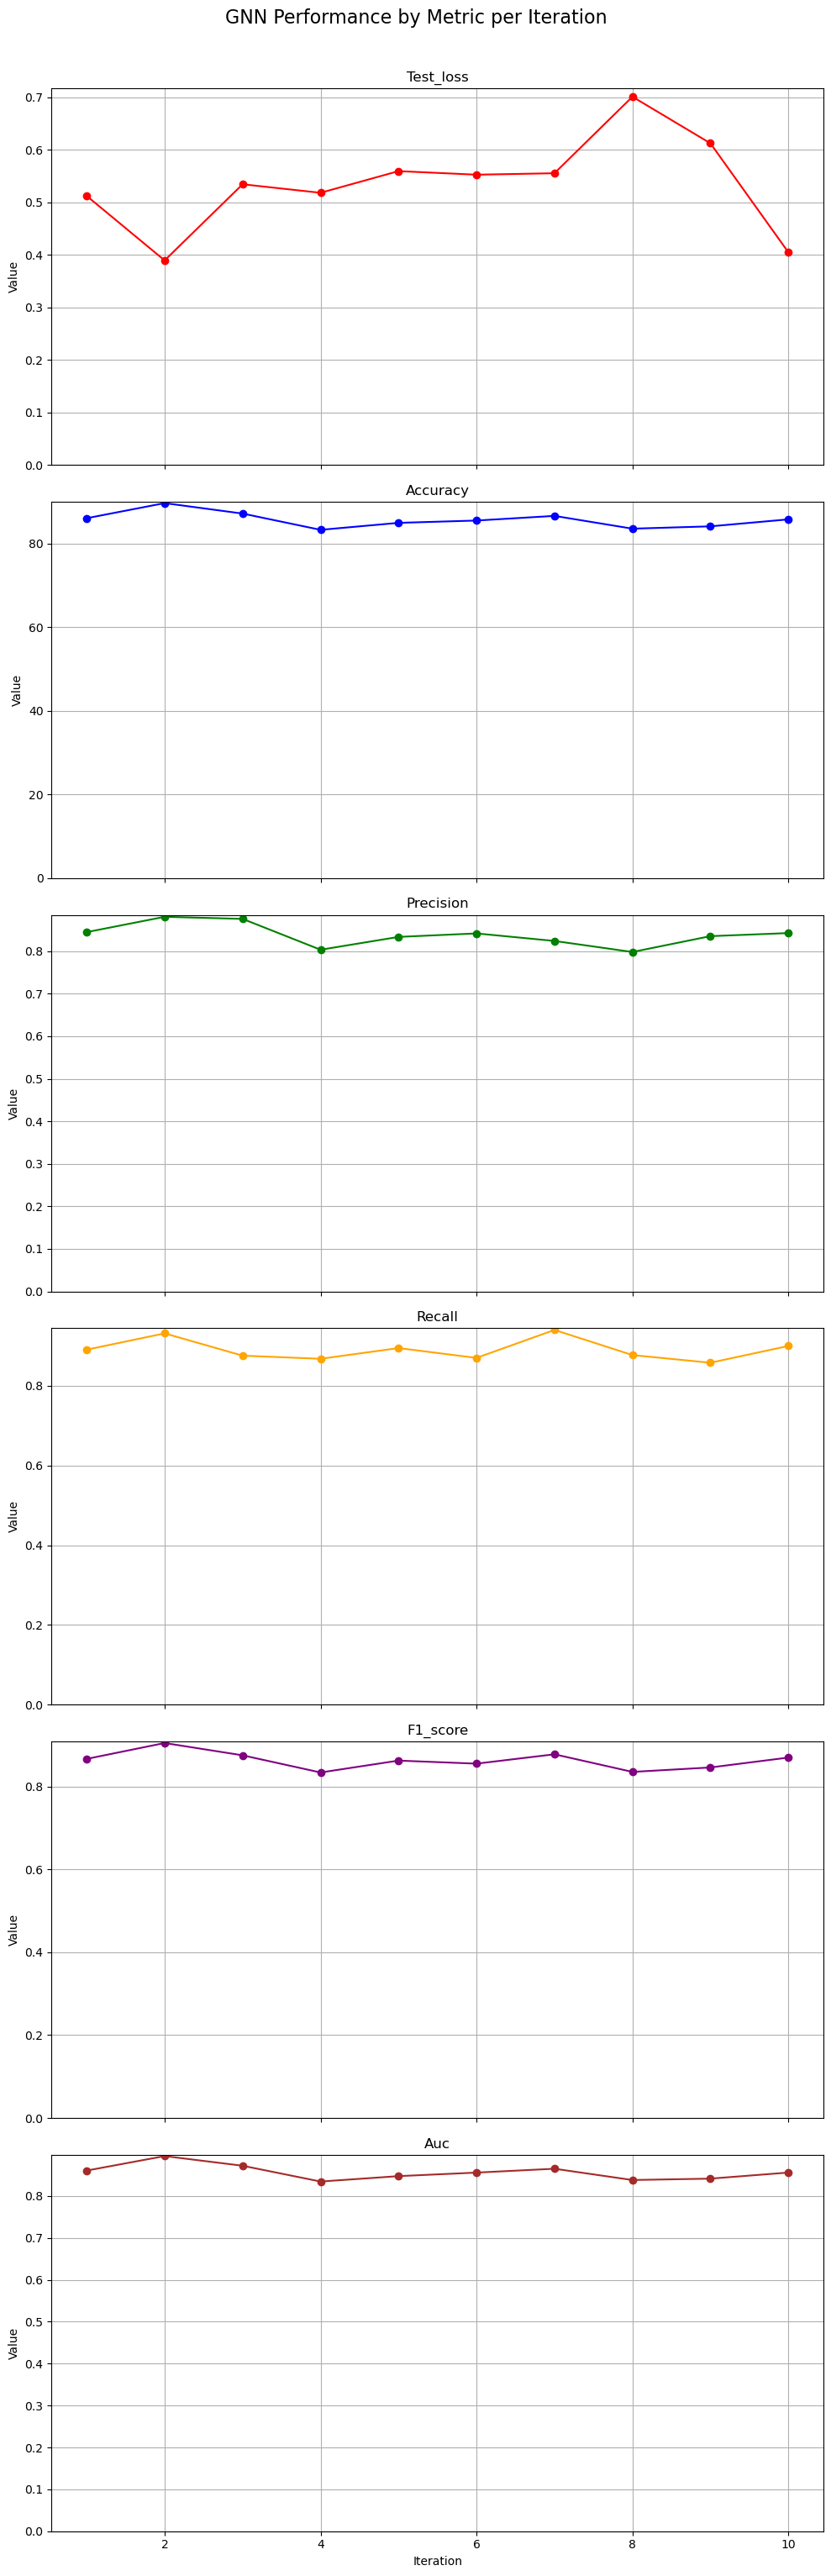

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

# 데이터프레임 정의
results_df = pd.DataFrame({
    "iteration": list(range(1, 11)),
    "test_loss": [0.511976, 0.389199, 0.534123, 0.517913, 0.559141, 0.552360, 0.555114, 0.700735, 0.612160, 0.404695],
    "accuracy": [86.111111, 89.722222, 87.222222, 83.333333, 85.0, 85.555556, 86.666667, 83.611111, 84.166667, 85.833333],
    "precision": [0.844560, 0.880597, 0.875676, 0.803191, 0.833333, 0.841530, 0.823810, 0.797872, 0.835106, 0.842365],
    "recall": [0.890710, 0.931579, 0.875676, 0.867816, 0.894737, 0.870056, 0.940217, 0.877193, 0.857923, 0.900000],
    "f1_score": [0.867021, 0.905371, 0.875676, 0.834254, 0.862944, 0.855556, 0.878173, 0.835655, 0.846361, 0.870229],
    "auc": [0.860609, 0.895201, 0.872124, 0.834446, 0.847368, 0.855793, 0.864995, 0.838067, 0.841391, 0.855882],
})

metrics = ['test_loss', 'accuracy', 'precision', 'recall', 'f1_score', 'auc']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

# 서브플롯 그리기
fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 30), sharex=True)

for i, (metric, color) in enumerate(zip(metrics, colors)):
    axes[i].plot(results_df['iteration'], results_df[metric], marker='o', color=color)
    axes[i].set_title(metric.capitalize(), fontsize=12)
    axes[i].set_ylabel("Value")
    axes[i].grid(True)
    axes[i].set_ylim(bottom=0)  # y축 하한을 0으로 설정

axes[-1].set_xlabel("Iteration")
plt.tight_layout()
plt.suptitle("GNN Performance by Metric per Iteration", fontsize=16, y=1.02)
plt.show()


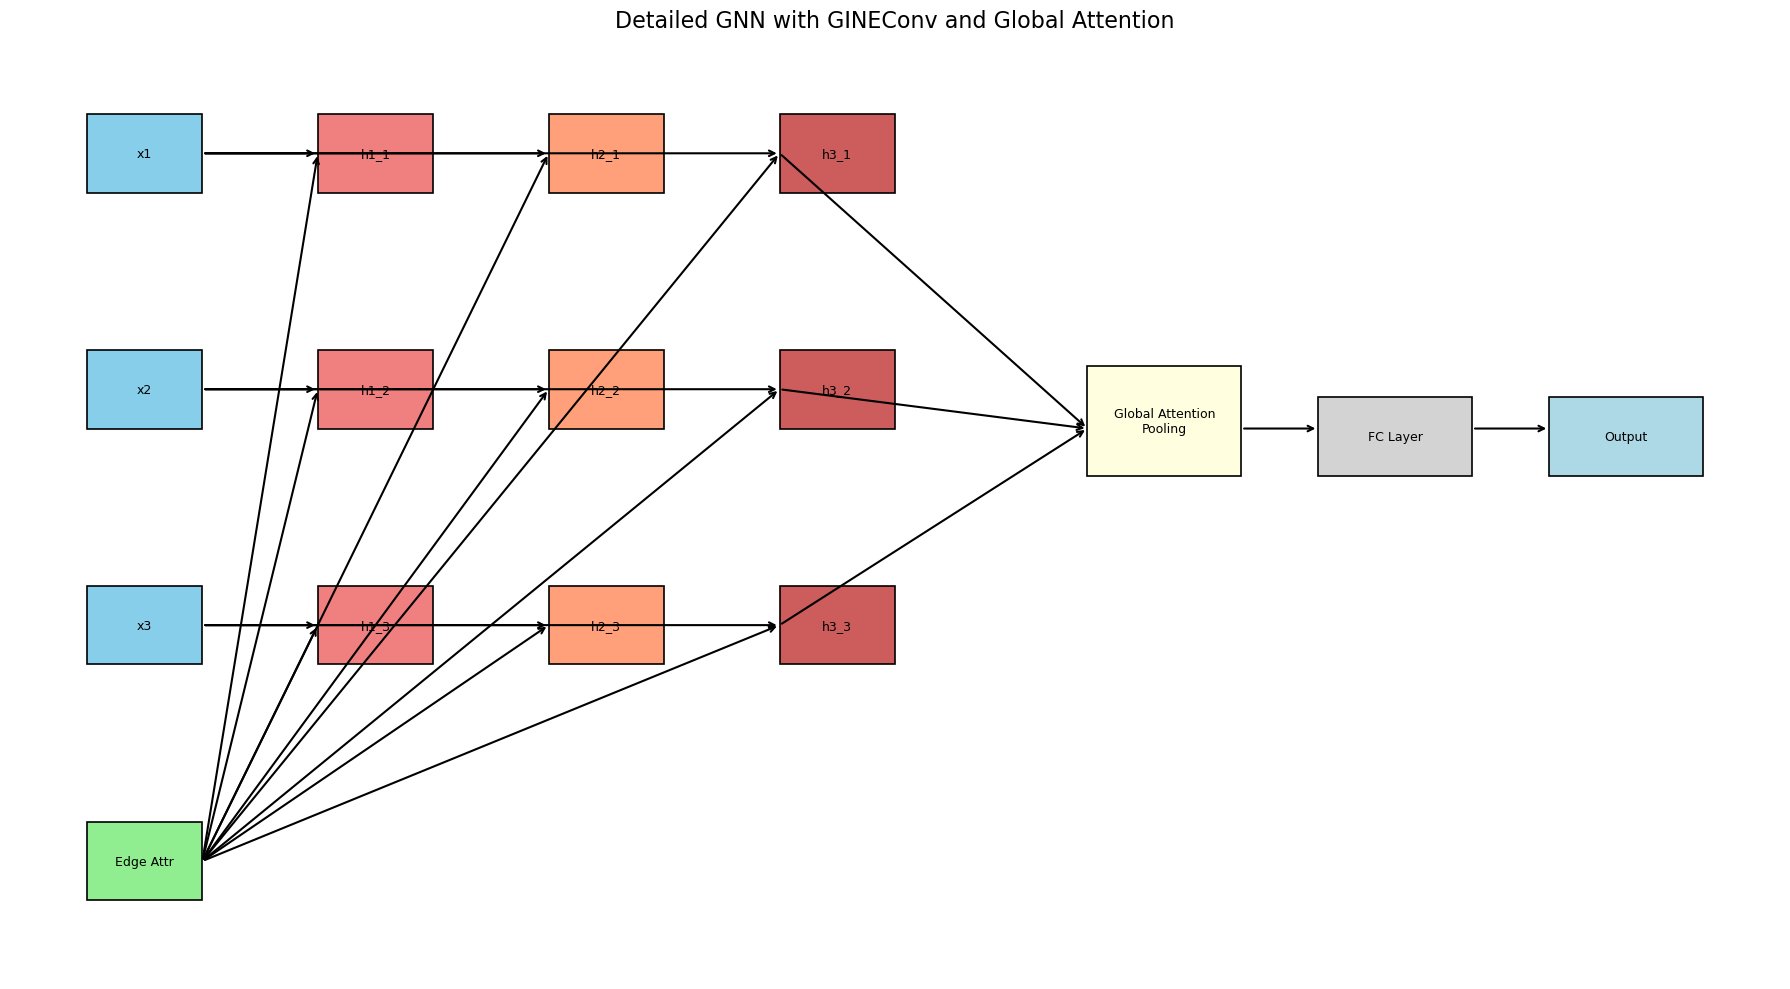

In [47]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_advanced_gnn_architecture():
    fig, ax = plt.subplots(figsize=(18, 10))

    def block(x, y, label, color='skyblue', width=1.5, height=0.5):
        rect = patches.Rectangle((x, y), width, height, linewidth=1.2, edgecolor='black', facecolor=color)
        ax.add_patch(rect)
        ax.text(x + width / 2, y + height / 2, label, ha='center', va='center', fontsize=9)

    def arrow(x1, y1, x2, y2):
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                    arrowprops=dict(arrowstyle='->', lw=1.5))

    # Input + Edge Attr
    input_xs = [0, 0, 0]
    input_ys = [8, 6.5, 5]
    for i in range(3):
        block(input_xs[i], input_ys[i], f"x{i+1}", 'skyblue')

    block(0, 3.5, "Edge Attr", 'lightgreen')

    # Conv Layers
    conv_colors = ['lightcoral', 'lightsalmon', 'indianred']
    y_levels = [8, 6.5, 5]
    for layer in range(3):
        for i in range(3):
            block(3 + layer * 3, y_levels[i], f"h{layer+1}_{i+1}", conv_colors[layer])
            arrow(0 + 1.5, y_levels[i] + 0.25, 3 + layer * 3, y_levels[i] + 0.25)  # input → conv1
            arrow(0 + 1.5, 3.75, 3 + layer * 3, y_levels[i] + 0.25)  # edge_attr → conv1

    # Global Pooling (합쳐짐)
    for i in range(3):
        arrow(3 + 6, y_levels[i] + 0.25, 13, 6.5)  # from conv3 → pooling center
    block(13, 6.2, "Global Attention\nPooling", 'lightyellow', width=2, height=0.7)

    # FC + Output
    block(16, 6.2, "FC Layer", 'lightgray', width=2)
    arrow(15, 6.5, 16, 6.5)
    block(19, 6.2, "Output", 'lightblue', width=2)
    arrow(18, 6.5, 19, 6.5)

    # Settings
    ax.set_xlim(-1, 22)
    ax.set_ylim(3, 9)
    ax.axis('off')
    plt.title("Detailed GNN with GINEConv and Global Attention", fontsize=16)
    plt.tight_layout()
    plt.show()

# 호출
draw_advanced_gnn_architecture()


In [32]:
"""
sampled_0 = random.sample(label_0, n_samples)
sampled_1 = random.sample(label_1, n_samples)
    
balanced_data = sampled_0 + sampled_1
random.shuffle(balanced_data)  

    # 훈련/테스트 분할
train_loader2 = DataLoader(balanced_data, batch_size=32, shuffle=True)

trainer2 = GNNTrainer(
        in_features=graph_data_list[0].x.size(1),
        hidden_dim=32,
        num_classes=2,
        lr=0.001,
        epochs=1000,  # 반복 적절히 조정 가능
    )
trainer2.train(train_loader2)
"""
# predict with lnp_graph_list
lnp_graph_batch = DataLoader(lnp_graph_list, batch_size=32, shuffle=False)
result = trainer.predict(lnp_graph_batch)
#결과를 df인 fg_summary에 추가
fg_summary['lnp_BBB'] = result

c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [33]:
fg_summary

,fg_name,fg_smarts,max_sasa,INSIDE,OUTSIDE,INSIDE (%),OUTSIDE (%),X (%),total_fg_count,compound_count,majority_label,lnp_smiles,lnp_BBB
0,fg1,CCC,178.09,10189,10235,49.9,50.1,0.0,20424,2357,OUTSIDE,OCCOP(=O)(OCCN)OC(COCCOCCOCCC)CO,1
1,fg2,CCC,178.09,10189,10235,49.9,50.1,0.0,20424,2357,OUTSIDE,OCCOP(=O)(OCCN)OC(COCCOCCOCCC)CO,1
2,fg3,CC(C)C,200.66,2270,2333,49.3,50.7,0.0,4603,1136,OUTSIDE,OCCOP(=O)(OCCN)OC(COCCOCCOCC(C)C)CO,1
3,fg4,c1cccc(Cl)c1,237.20,0,549,0.0,100.0,0.0,549,425,OUTSIDE,OCCOP(=O)(OCCN)OC(COCCOCCOc1cccc(Cl)c1)CO,1
4,fg5,N(C=O)CC,208.86,364,2452,12.9,87.1,0.0,2816,850,OUTSIDE,OCCOP(=O)(OCCN)OC(COCCOCCON(C=O)CC)CO,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,fg285,[C@@](C)(O)CCC,243.92,2139,3511,37.9,62.1,0.0,5650,594,OUTSIDE,OCCOP(=O)(OCCN)OC(COCCOCCO[C@@](C)(O)CCC)CO,1
285,fg286,[C@H](C)CCCC(C)C,303.86,1654,2957,35.9,64.1,0.0,4611,314,OUTSIDE,OCCOP(=O)(OCCN)OC(COCCOCCO[C@H](C)CCCC(C)C)CO,1
286,fg287,[C@](C)(O)C(C)(C)C,255.18,81,268,23.2,76.8,0.0,349,178,OUTSIDE,OCCOP(=O)(OCCN)OC(COCCOCCO[C@](C)(O)C(C)(C)C)CO,1
287,fg288,[C@](C)(O)CCC,243.92,2139,3511,37.9,62.1,0.0,5650,594,OUTSIDE,OCCOP(=O)(OCCN)OC(COCCOCCO[C@](C)(O)CCC)CO,1


In [25]:
olnp_graph_batch = DataLoader(only_lnp_graph, batch_size=32, shuffle=False)
result_o = trainer.predict(olnp_graph_batch)
#결과를 df인 fg_summary에 추가
result_o

c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


array([1], dtype=int64)

In [26]:
lnp_graph_batch2 = DataLoader(lnp_graph_list_neg, batch_size=32, shuffle=False)
result2 = trainer.predict(lnp_graph_batch2)
#결과를 df인 fg_summary에 추가
nfg_summary['lnp_BBB'] = result2

In [34]:
fg_graph_batch = DataLoader(fg_graph, batch_size=32, shuffle=False)
result_fg = trainer.predict(fg_graph_batch)
fg_summary['fg_BBB'] = result_fg

c:\Users\jubee\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


ValueError: Length of values (253) does not match length of index (259)

In [ ]:
fg_bbb_counts = fg_summary['fg_BBB'].value_counts()
print(f"fg_BBB의 0과 1의 개수:\n{fg_bbb_counts}")

fg_BBB의 0과 1의 개수:
fg_BBB
1    241
0     14
Name: count, dtype: int64


In [ ]:
nfg_graph_batch = DataLoader(nfg_graph, batch_size=32, shuffle=False)
result_nfg = trainer.predict(nfg_graph_batch)
nfg_summary['fg_BBB'] = result_nfg

c:\Users\imowl\miniconda3\envs\ml\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
nfg_bbb_counts = nfg_summary['fg_BBB'].value_counts()
print(f"nfg_BBB의 0과 1의 개수:\n{nfg_bbb_counts}")

nfg_BBB의 0과 1의 개수:
fg_BBB
1    57
0    36
Name: count, dtype: int64


In [ ]:
# fg_summary에서 lnp_BBB의 0과 1의 개수
lnp_bbb_counts = fg_summary['lnp_BBB'].value_counts()
print(f"lnp_BBB의 0과 1의 개수:\n{lnp_bbb_counts}")


lnp_BBB의 0과 1의 개수:
lnp_BBB
1    224
0     31
Name: count, dtype: int64


In [ ]:
lnp_bbb_counts2 = nfg_summary['lnp_BBB'].value_counts()
print(f"lnp_BBB의 0과 1의 개수(neg):\n{lnp_bbb_counts2}")

lnp_BBB의 0과 1의 개수(neg):
lnp_BBB
1    77
0    16
Name: count, dtype: int64


In [ ]:
fg_summary

,fg_name,fg_smarts,INSIDE,OUTSIDE,INSIDE (%),OUTSIDE (%),X (%),total_fg_count,compound_count,majority_label,lnp_smiles,lnp_BBB
0,fg1,CCC,10194,10208,50.0,50.0,0.0,20402,2357,OUTSIDE,OCCOP(=O)(OCCN)OC(COCCOCCOCCC)CO,1
1,fg2,CCC,10194,10208,50.0,50.0,0.0,20402,2357,OUTSIDE,OCCOP(=O)(OCCN)OC(COCCOCCOCCC)CO,1
2,fg3,CC(C)C,2265,2340,49.2,50.8,0.0,4605,1136,OUTSIDE,OCCOP(=O)(OCCN)OC(COCCOCCOCC(C)C)CO,1
3,fg4,c1cccc(Cl)c1,0,549,0.0,100.0,0.0,549,425,OUTSIDE,OCCOP(=O)(OCCN)OC(COCCOCCOc1cccc(Cl)c1)CO,1
4,fg5,N(C=O)CC,348,2448,12.4,87.6,0.0,2796,849,OUTSIDE,OCCOP(=O)(OCCN)OC(COCCOCCON(C=O)CC)CO,1
...,...,...,...,...,...,...,...,...,...,...,...,...
283,fg284,[C@@H](O)C(C)C,369,406,47.6,52.4,0.0,775,344,OUTSIDE,OCCOP(=O)(OCCN)OC(COCCOCCO[C@@H](O)C(C)C)CO,0
284,fg285,[C@@](C)(O)CCC,2110,3540,37.3,62.7,0.0,5650,594,OUTSIDE,OCCOP(=O)(OCCN)OC(COCCOCCO[C@@](C)(O)CCC)CO,1
285,fg286,[C@H](C)CCCC(C)C,1656,2955,35.9,64.1,0.0,4611,314,OUTSIDE,OCCOP(=O)(OCCN)OC(COCCOCCO[C@H](C)CCCC(C)C)CO,1
286,fg287,[C@](C)(O)C(C)(C)C,76,273,21.8,78.2,0.0,349,178,OUTSIDE,OCCOP(=O)(OCCN)OC(COCCOCCO[C@](C)(O)C(C)(C)C)CO,1


In [ ]:
fg_summary.to_csv("fg_result_positive.csv", index=False)

In [ ]:
nfg_summary.to_csv("nfg_result_negative.csv", index=False)

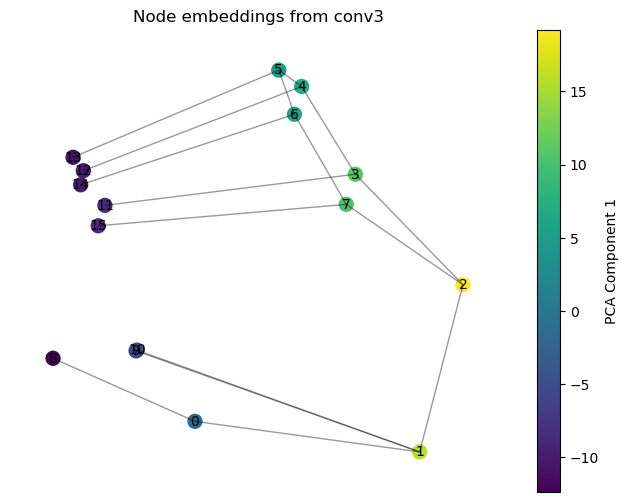

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch_geometric.utils import to_networkx
import networkx as nx

def visualize_node_embeddings(model, data, layer="conv3"):
    model.eval()
    with torch.no_grad():
        # edge_attr 임베딩 처리
        edge_attr = model.edge_nn(data.edge_attr)
        x = data.x
        
        # 각 conv 단계의 출력을 저장
        x1 = model.conv1(x, data.edge_index, edge_attr)
        x1 = F.relu(x1)
        x2 = model.conv2(x1, data.edge_index, edge_attr)
        x2 = F.relu(x2)
        x3 = model.conv3(x2, data.edge_index, edge_attr)

        # 시각화 대상 선택
        if layer == "conv1":
            embeddings = x1
        elif layer == "conv2":
            embeddings = x2
        else:
            embeddings = x3
        
        # PCA를 이용한 2D 시각화
        pca = PCA(n_components=2)
        node_pos = pca.fit_transform(embeddings.cpu().numpy())
        
        # NetworkX 그래프 변환
        G = to_networkx(data, to_undirected=True)
        
        # 노드 위치 매핑
        pos = {i: node_pos[i] for i in range(data.num_nodes)}
        
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(x=node_pos[:, 0], y=node_pos[:, 1], c=node_pos[:, 0], cmap='viridis', s=100)
        nx.draw_networkx_edges(G, pos, alpha=0.4)
        nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
        plt.title(f"Node embeddings from {layer}")
        plt.axis('off')
        plt.colorbar(scatter, label="PCA Component 1")
        plt.show()

# 사용 예시
visualize_node_embeddings(trainer.model, graph_data_list[0], layer="conv3")

In [ ]:
graph_data_list[0].x[:, -3:]

tensor([[ 2.5400, -0.2341, -0.9543],
        [ 1.9632, -0.1293,  0.3167],
        [ 0.4720, -0.0261,  0.1781],
        [-0.3180, -1.1871,  0.1400],
        [-1.7036, -1.0907, -0.0240],
        [-2.3072,  0.1622, -0.1626],
        [-1.5257,  1.3208, -0.1421],
        [-0.1398,  1.2288,  0.0216],
        [ 3.5194, -0.2992, -0.8076],
        [ 2.3601,  0.7702,  0.8389],
        [ 2.2279, -1.0222,  0.9267],
        [ 0.1381, -2.1647,  0.2370],
        [-2.3089, -1.9877, -0.0473],
        [-3.3795,  0.2351, -0.2907],
        [-1.9934,  2.2902, -0.2568],
        [ 0.4552,  2.1338,  0.0265]])

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import networkx as nx

def visualize_node_embeddings(model, data, layer="conv3", use_3d=False):
    model.eval()
    with torch.no_grad():
        edge_attr = model.edge_nn(data.edge_attr)
        x = data.x

        # GNN 레이어 순차 적용
        x1 = model.conv1(x, data.edge_index, edge_attr)
        x1 = F.relu(x1)
        x2 = model.conv2(x1, data.edge_index, edge_attr)
        x2 = F.relu(x2)
        x3 = model.conv3(x2, data.edge_index, edge_attr)

        # 선택된 레이어의 임베딩
        if layer == "conv1":
            embeddings = x1
        elif layer == "conv2":
            embeddings = x2
        else:
            embeddings = x3

        # NetworkX 그래프로 변환
        G = to_networkx(data, to_undirected=True)

        if use_3d:
            # 분자 좌표로 시각화
            coords = data.x[:, -3:].cpu().numpy()

            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')

            # 노드 위치 매핑
            for i, (x, y, z) in enumerate(coords):
                ax.scatter(x, y, z, color='skyblue', s=100)
                ax.text(x, y, z, f'{i}', fontsize=9)

            # 엣지 그리기
            edge_index = data.edge_index.cpu().numpy()
            for i in range(edge_index.shape[1]):
                start = coords[edge_index[0, i]]
                end = coords[edge_index[1, i]]
                ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], color='gray', alpha=0.5)

            ax.set_title(f"3D Molecular Structure (from {layer})")
            ax.set_xlabel("X")
            ax.set_ylabel("Y")
            ax.set_zlabel("Z")
            plt.tight_layout()
            plt.show()

        else:
            # PCA를 통한 2D 시각화
            node_pos = PCA(n_components=2).fit_transform(embeddings.cpu().numpy())
            pos = {i: node_pos[i] for i in range(data.num_nodes)}

            plt.figure(figsize=(8, 6))
            scatter = plt.scatter(node_pos[:, 0], node_pos[:, 1], c=node_pos[:, 0], cmap='viridis', s=100)
            nx.draw_networkx_edges(G, pos, alpha=0.4)
            nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
            plt.title(f"Node embeddings from {layer} (PCA)")
            plt.axis('off')
            plt.colorbar(scatter, label="PCA Component 1")
            plt.show()


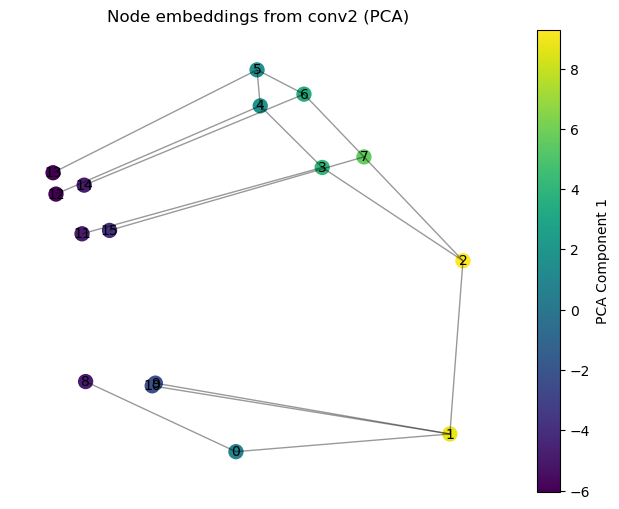

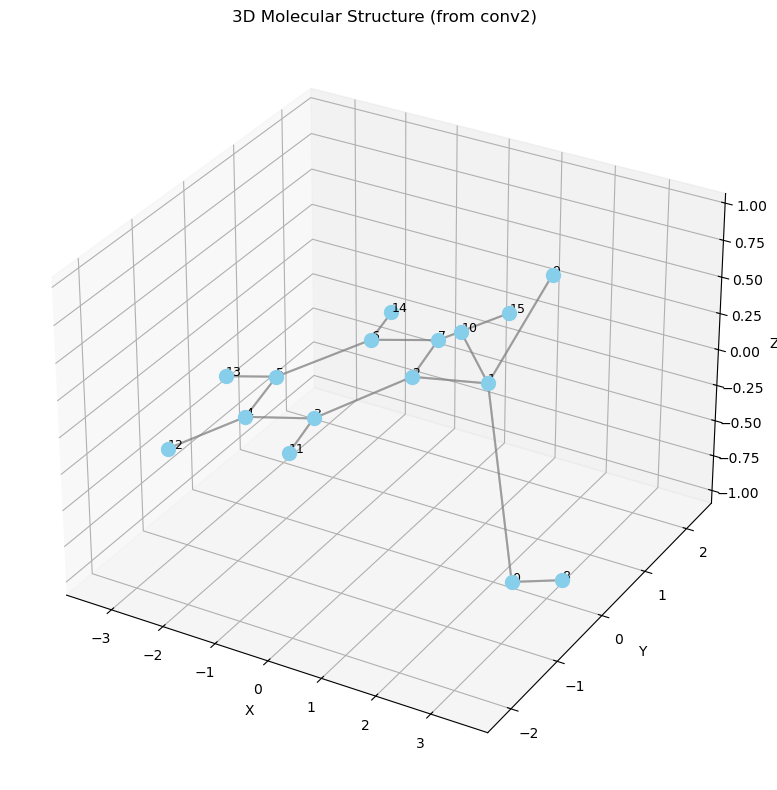

In [ ]:
# 기존처럼 2D 시각화
visualize_node_embeddings(trainer.model, graph_data_list[0], layer="conv2")

# 3D 구조 기반 시각화
visualize_node_embeddings(trainer.model, graph_data_list[0], layer="conv2", use_3d=True)

In [ ]:
def visualize_node_embeddings(model, data, layer="conv3", use_3d=False):
    model.eval()
    with torch.no_grad():
        edge_attr = model.edge_nn(data.edge_attr)
        x = data.x

        # GNN 레이어 통과
        x1 = model.conv1(x, data.edge_index, edge_attr)
        x1 = F.relu(x1)
        x2 = model.conv2(x1, data.edge_index, edge_attr)
        x2 = F.relu(x2)
        x3 = model.conv3(x2, data.edge_index, edge_attr)

        if layer == "conv1":
            embeddings = x1
        elif layer == "conv2":
            embeddings = x2
        else:
            embeddings = x3

        G = to_networkx(data, to_undirected=True)

        # 🎯 중요도 계산 (여기서는 벡터 크기 사용)
        importance = embeddings.norm(dim=1).cpu().numpy()  # (num_nodes,)

        if use_3d:
            coords = data.x[:, -3:].cpu().numpy()

            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')

            # 중요도 값에 따라 색상 매핑
            sc = ax.scatter(
                coords[:, 0], coords[:, 1], coords[:, 2],
                c=importance,
                cmap='coolwarm',
                s=100, edgecolors='k'
            )

            # 노드 라벨
            for i, (x, y, z) in enumerate(coords):
                ax.text(x, y, z, f'{i}', fontsize=9)

            # 엣지 연결
            edge_index = data.edge_index.cpu().numpy()
            for i in range(edge_index.shape[1]):
                start = coords[edge_index[0, i]]
                end = coords[edge_index[1, i]]
                ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], color='gray', alpha=0.4)

            ax.set_title(f"3D Molecular Structure with Importance (from {layer})")
            ax.set_xlabel("X")
            ax.set_ylabel("Y")
            ax.set_zlabel("Z")
            fig.colorbar(sc, label="Node Importance (norm of embedding)")
            plt.tight_layout()
            plt.show()

        else:
            # 2D PCA 시각화
            node_pos = PCA(n_components=2).fit_transform(embeddings.cpu().numpy())
            pos = {i: node_pos[i] for i in range(data.num_nodes)}

            plt.figure(figsize=(8, 6))
            scatter = plt.scatter(
                node_pos[:, 0], node_pos[:, 1],
                c=importance,
                cmap='coolwarm',
                s=100
            )
            nx.draw_networkx_edges(G, pos, alpha=0.4)
            nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
            plt.title(f"Node embeddings from {layer} (PCA)")
            plt.axis('off')
            plt.colorbar(scatter, label="Node Importance (norm of embedding)")
            plt.show()


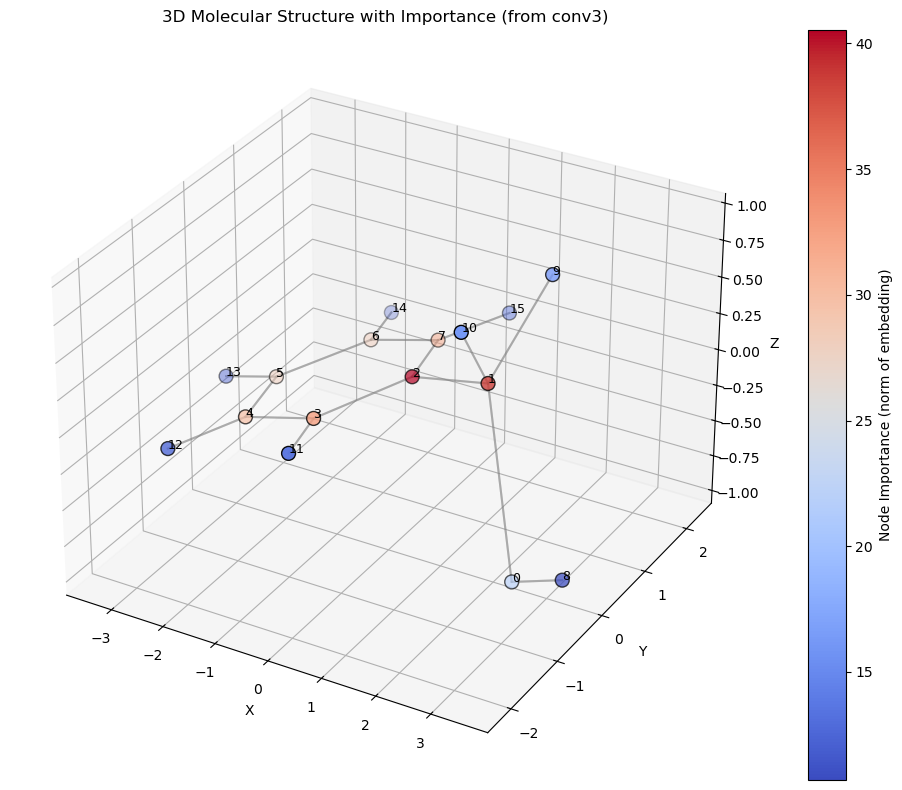

In [ ]:
# 3D 구조 위에 중요도 표시!
visualize_node_embeddings(trainer.model, graph_data_list[0], layer="conv3", use_3d=True)

In [ ]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_explainer_output_3d(data, node_mask, edge_mask, title="3D GNN Explanation"):
    coords = data.x[:, -3:].cpu().numpy()  # 3D 좌표
    edge_index = data.edge_index.cpu().numpy()
    node_mask = node_mask.cpu().numpy()
    edge_mask = edge_mask.cpu().numpy()

    if node_mask.ndim == 2:
        node_mask = node_mask.mean(axis=1)

    # numpy 배열로 변환
    node_mask = node_mask.detach().cpu().numpy() if hasattr(node_mask, 'detach') else node_mask

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    print("coords.shape:", coords.shape)
    print("node_mask.shape:", node_mask.shape)


    # 노드 시각화: 중요도에 따라 색상과 크기 조절
    sc = ax.scatter(
        coords[:, 0], coords[:, 1], coords[:, 2],
        c=node_mask,
        cmap='coolwarm',
        s=100 + 300 * node_mask,  # 중요도에 따라 노드 크기 조절
        edgecolors='k'
    )

    # 노드 라벨 표시
    for i, (x, y, z) in enumerate(coords):
        ax.text(x, y, z, f'{i}', fontsize=9)

    # 엣지 시각화: 중요도에 따라 굵기 및 색상 조절
    norm_edge_mask = (edge_mask - edge_mask.min()) / (edge_mask.max() - edge_mask.min() + 1e-6)  # 정규화
    for i in range(edge_index.shape[1]):
        start = coords[edge_index[0, i]]
        end = coords[edge_index[1, i]]
        importance = norm_edge_mask[i]
        ax.plot(
            [start[0], end[0]],
            [start[1], end[1]],
            [start[2], end[2]],
            color=plt.cm.coolwarm(importance),
            linewidth=1 + 4 * importance,
            alpha=0.7
        )

    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    fig.colorbar(sc, label="Node Importance")
    plt.tight_layout()
    plt.show()

data=graph_data_list[0]

# explainer를 통해 얻은 결과
explanation = explainer(
    data.x,
    data.edge_index,
    edge_attr=data.edge_attr,
    batch=data.batch,
)


# 시각화
visualize_explainer_output_3d(
    data=graph_data_list[0],
    node_mask=explanation.node_mask,
    edge_mask=explanation.edge_mask,
    title="3D Explanation Visualization"
)


NameError: name 'explainer' is not defined

In [ ]:
!pip install shap

ExactExplainer explainer: 2556it [9:17:32, 13.09s/it]                            


클래스 0 (비통과): SHAP summary plot


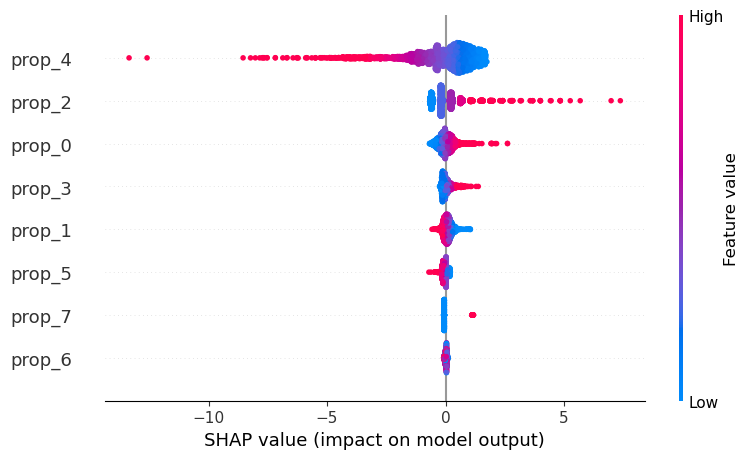


[클래스 0 - 평균 SHAP 영향도 순위]
prop_4: 1.0640
prop_2: 0.4763
prop_0: 0.2332
prop_3: 0.1369
prop_1: 0.1365
prop_5: 0.0831
prop_7: 0.0744
prop_6: 0.0294


C:\Users\jubee\AppData\Local\Temp\ipykernel_13500\3434578229.py:52: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jubee\AppData\Local\Temp\ipykernel_13500\3434578229.py:52: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jubee\AppData\Local\Temp\ipykernel_13500\3434578229.py:52: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jubee\AppData\Local\Temp\ipykernel_13500\3434578229.py:52: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jubee\AppData\Local\Temp\ipykernel_13500\3434578229.py:52: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jubee\AppData\Local\Temp\ipykernel_13500\3434578229.py:52: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing fr

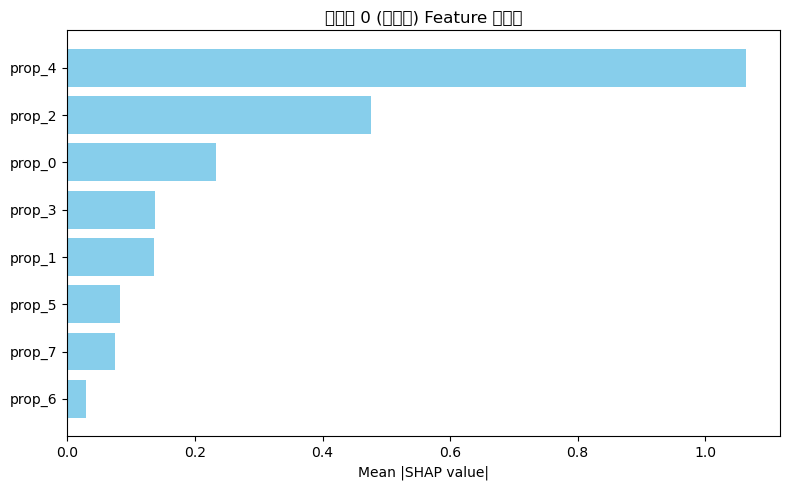


클래스 1 (통과): SHAP summary plot


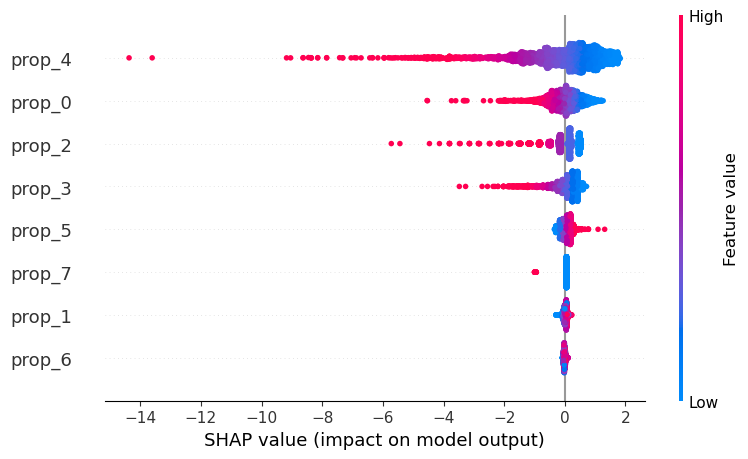


[클래스 1 - 평균 SHAP 영향도 순위]
prop_4: 1.1310
prop_0: 0.4100
prop_2: 0.3781
prop_3: 0.3568
prop_5: 0.1511
prop_7: 0.0651
prop_1: 0.0473
prop_6: 0.0235


C:\Users\jubee\AppData\Local\Temp\ipykernel_13500\3434578229.py:74: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jubee\AppData\Local\Temp\ipykernel_13500\3434578229.py:74: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jubee\AppData\Local\Temp\ipykernel_13500\3434578229.py:74: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jubee\AppData\Local\Temp\ipykernel_13500\3434578229.py:74: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jubee\AppData\Local\Temp\ipykernel_13500\3434578229.py:74: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jubee\AppData\Local\Temp\ipykernel_13500\3434578229.py:74: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing

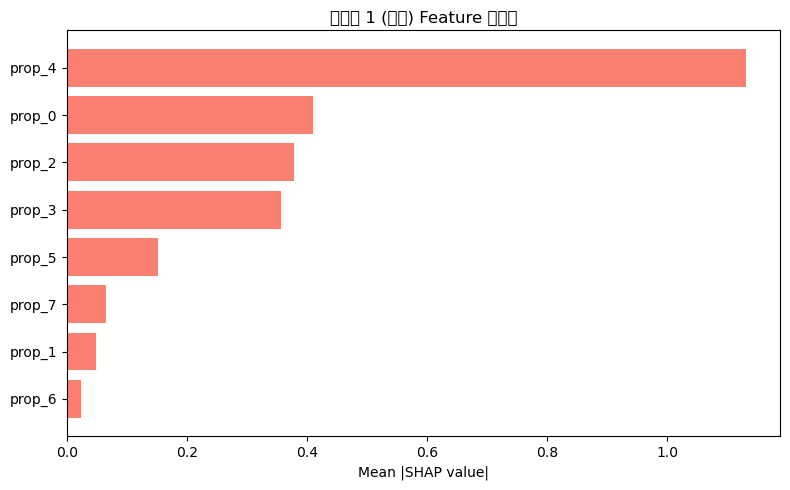

In [ ]:
import shap
import numpy as np
import torch
import matplotlib.pyplot as plt

# ✅ Wrapper 클래스 정의
class MolPropWrapper:
    def __init__(self, model, data_list):
        self.model = model
        self.data_list = data_list

    def __call__(self, mol_props_numpy):
        self.model.eval()
        outputs = []
        n_data = len(self.data_list)
        for i in range(len(mol_props_numpy)):
            data = self.data_list[i % n_data]
            data = data.clone()
            data.mol_properties = torch.tensor(mol_props_numpy[i]).unsqueeze(0).float()
            out = self.model.forward_by_data(data)
            outputs.append(out.detach().cpu().numpy())
        return np.vstack(outputs)

# ✅ 모델과 데이터 준비
wrapper_model = MolPropWrapper(trainer.model, graph_data_list)
X_mol_props = np.array([data.mol_properties.squeeze(0).numpy() for data in graph_data_list])
feature_names = [f"prop_{i}" for i in range(X_mol_props.shape[1])]

# ✅ SHAP 계산
explainer = shap.Explainer(wrapper_model, X_mol_props)
shap_values = explainer(X_mol_props)  # shape: (N, 8, 2)

# ✅ 클래스 0 summary plot
print("클래스 0 (비통과): SHAP summary plot")
shap.summary_plot(shap_values[..., 0], X_mol_props, feature_names=feature_names)

# ✅ 클래스 0 영향도 계산 및 시각화
mean_shap_class0 = np.mean(np.abs(shap_values.values[..., 0]), axis=0)
sorted_idx0 = np.argsort(mean_shap_class0)[::-1]

# 정량 출력
print("\n[클래스 0 - 평균 SHAP 영향도 순위]")
for i in sorted_idx0:
    print(f"{feature_names[i]}: {mean_shap_class0[i]:.4f}")

# 시각화
plt.figure(figsize=(8, 5))
plt.barh([feature_names[i] for i in sorted_idx0], mean_shap_class0[sorted_idx0], color="skyblue")
plt.xlabel("Mean |SHAP value|")
plt.title("클래스 0 (비통과) Feature 영향도")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ✅ 클래스 1 summary plot
print("\n클래스 1 (통과): SHAP summary plot")
shap.summary_plot(shap_values[..., 1], X_mol_props, feature_names=feature_names)

# ✅ 클래스 1 영향도 계산 및 시각화
mean_shap_class1 = np.mean(np.abs(shap_values.values[..., 1]), axis=0)
sorted_idx1 = np.argsort(mean_shap_class1)[::-1]

# 정량 출력
print("\n[클래스 1 - 평균 SHAP 영향도 순위]")
for i in sorted_idx1:
    print(f"{feature_names[i]}: {mean_shap_class1[i]:.4f}")

# 시각화
plt.figure(figsize=(8, 5))
plt.barh([feature_names[i] for i in sorted_idx1], mean_shap_class1[sorted_idx1], color="salmon")
plt.xlabel("Mean |SHAP value|")
plt.title("클래스 1 (통과) Feature 영향도")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
# 하이퍼파라미터 그리드 설정: 신경망 용
param_grid = {
    'hidden_dim': [32, 64, 128, 256], # 은닉층 크기
    'lr': [0.0001, 0.001], # 학습률
    'epochs': [1000, 5000, 10000] # 에폭 수
}

# GridSearchCV 설정
gnn_trainers = GNNTrainer(in_features=1, hidden_dim=64, global_dim= len(float_columns), lr=0.0001, epochs=1000)
grid_search = GridSearchCV(gnn_trainers, param_grid, cv=3, verbose=3, scoring='neg_mean_squared_error')
#cv는 교차검증을 3-폴드로 수행. verbose는 각 단계에서의 진행 상황 출력. 평가 지표 scoring으로는 음수 평균제곱오차

# 데이터 로드
# X_train, y_train, X_test, y_test = data_train, target_train, data_test, target_test

# 그리드 서치 실행
data_train, data_test, target_train, target_test = splitter(data_filtered, target_filtered, 1)
data_train = processor.preprocess_data(data_train)
data_test = processor.preprocess_data(data_test)

graph_data_train = processor.create_graph(data_train['CGR'], data_train['mol_full'], target_train)
graph_data_test = processor.create_graph(data_test['CGR'], data_test['mol_full'], target_test)
grid_search.fit(graph_data_train, data_train[float_columns])

# 최적의 파라미터 출력
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(-grid_search.best_score_))
best_params = grid_search.best_params_

# 테스트 데이터에 대한 성능 평가
#test_score = grid_search.score(data_test, target_test)
#print("Test set score: {:.2f}".format(-test_score))

NameError: name 'float_columns' is not defined